# 用PINN控制一个弹簧震动

## 无监督的学习
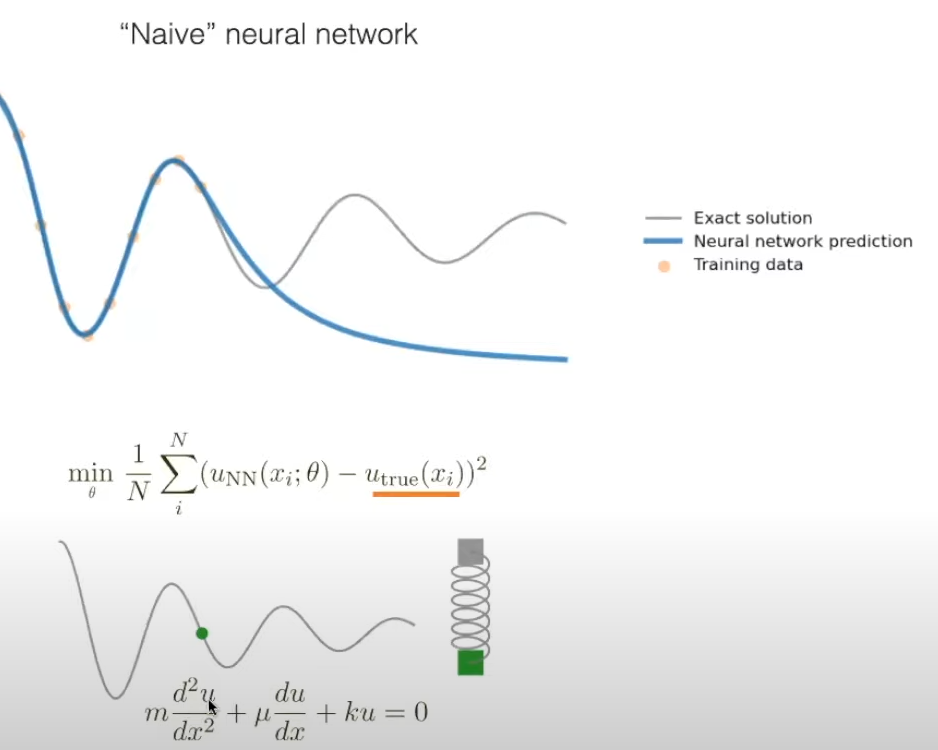

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

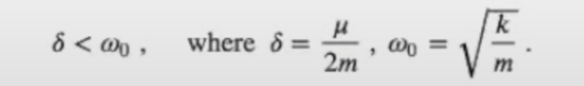
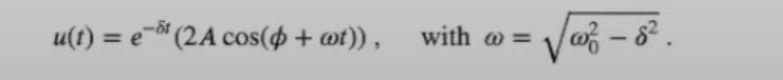

In [2]:
def exact_sloution(d, w0, t):
    assert d < w0
    w = np.sqrt(w0**2 - d**2)
    phi = np.arctan(-d / w)
    A = 1 / (2 * np.cos(phi))
    cos = torch.cos(phi + w * t)
    exp = torch.exp(-d * t)
    u = 2 * A * exp * cos
    return u


class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(
            *[
                nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()])
                for i in range(N_LAYERS - 1)
            ]
        )
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [17]:
torch.manual_seed(0)

pinn = FCN(1, 1, 32, 3)

# LOSS:
t_bounday = torch.tensor(0.0).view(-1, 1).requires_grad_(True)
t_physics = torch.linspace(0, 1, 60).view(-1, 1).requires_grad_(True)

d, w0 = 2, 20
mu, k = 2 * d, w0**2 # 感觉这里假设了m=1
t_test = torch.linspace(0, 1, 300).view(-1, 1)
u_exact = exact_sloution(d, w0, t_test)
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

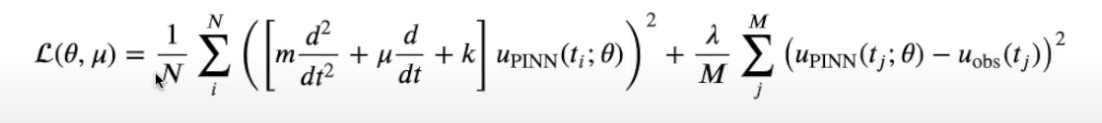

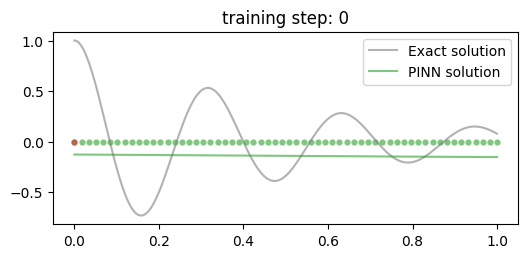

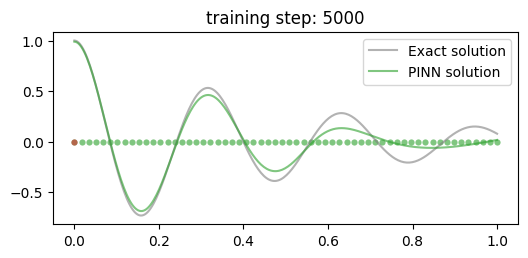

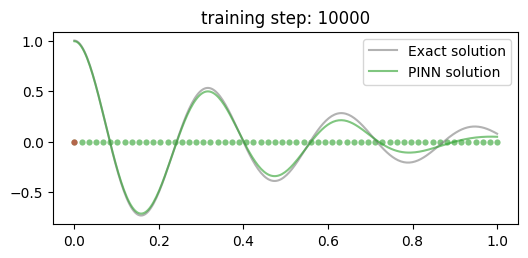

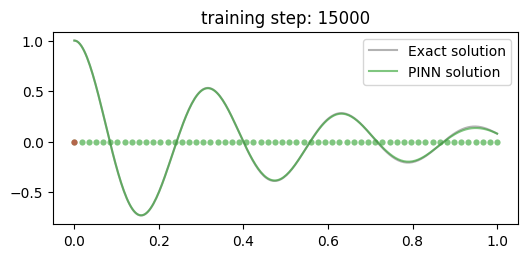

In [18]:
for i in range(15001):
    optimizer.zero_grad()
    lambba1, lambda2 = 1e-1, 1e-4
    # 添加了边界条件，初始位置和初速度
    u = pinn(t_bounday)  # (1,1)
    loss1 = (torch.squeeze(u) - 1) ** 2
    dudt = torch.autograd.grad(u, t_bounday, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0) ** 2

    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(
        dudt, t_physics, torch.ones_like(dudt), create_graph=True
    )[0]
    loss3 = torch.mean((d2udt2 + mu * dudt + k * u) ** 2)#
    # loss3 = torch.mean(((d2udt2 + mu * dudt + k) * u) ** 2)#

    loss = loss1 + lambba1*loss2 + lambda2*loss3
    loss.backward()
    optimizer.step()
    
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6, 2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0],s=20,lw=0,color='tab:green',alpha=0.6)
        plt.scatter(t_bounday.detach()[:,0],
                    torch.zeros_like(t_bounday)[:,0],s=20,lw=0,color='tab:red',alpha=0.6)
        plt.plot(t_test[:,0],u_exact[:,0],label='Exact solution',color='tab:grey',alpha=0.6)
        plt.plot(t_test[:,0],u[:,0],label='PINN solution',color='tab:green',alpha=0.6)
        plt.title(f'training step: {i}')
        plt.legend()
        plt.show()
        
        
        
        

## 利用数据进行有监督的训练

true value of mu:4


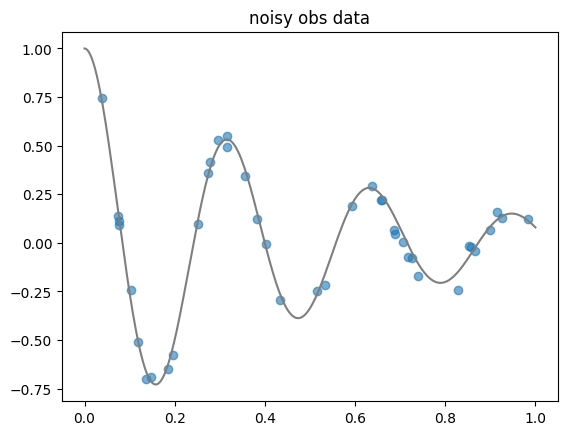

In [26]:
torch.manual_seed(123)
d, w0 = 2, 20
print(f'true value of mu:{2*d}')
t_obs = torch.rand(40).view(-1, 1) 
u_obs = exact_sloution(d, w0, t_obs) + torch.randn_like(t_obs) * 0.04

plt.figure()
plt.title('noisy obs data')
plt.scatter(t_obs.detach(), u_obs.detach(), color='tab:blue', alpha=0.6)
t_test,u_exact = torch.linspace(0, 1, 300).view(-1, 1),exact_sloution(d, w0, t_test)
plt.plot(t_test[:,0],u_exact[:,0],label='Exact solution',color='tab:grey',alpha=1)
plt.show()

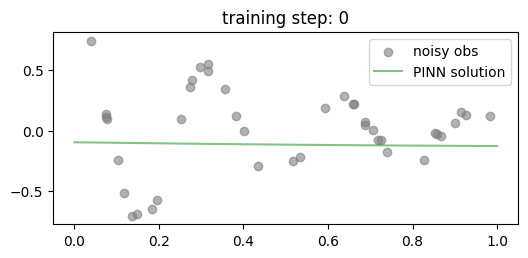

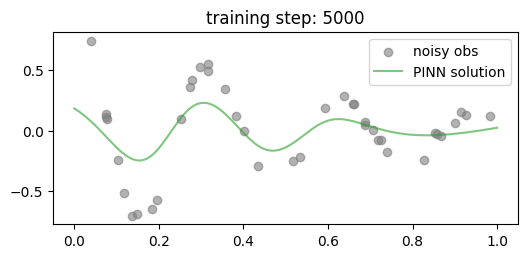

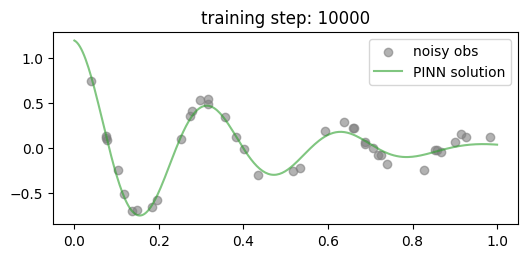

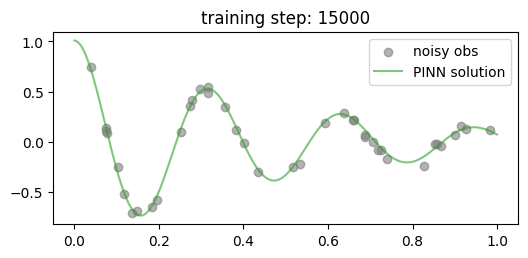

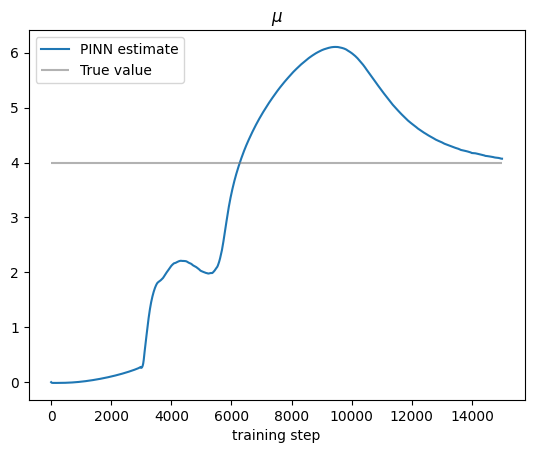

In [28]:
torch.manual_seed(123)
pinn = FCN(1, 1, 32, 4)
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
d, w0 = 2, 20
_,k = 2*d,w0**2

# mu = torch.nn.Parameter(torch.zeros(1,requeires_grad=True))
mu = nn.Parameter(torch.zeros(1, requires_grad=True))
mus = []
optimizer = torch.optim.Adam(list(pinn.parameters())+[mu], lr=1e-3)
for i in range(15001):
    optimizer.zero_grad()
    lambba1 = 1e4 # 超参数的选择甚至关系到网络收敛不收敛

    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(
        dudt, t_physics, torch.ones_like(dudt), create_graph=True
    )[0]
    loss1 = torch.mean((d2udt2 + mu * dudt + k * u) ** 2)
     
    
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs) ** 2)
    loss = loss1 + lambba1*loss2
    loss.backward()
    optimizer.step()
    mus.append(mu.item())
    if i % 5000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6, 2.5))
        plt.scatter(t_obs[:,0],u_obs[:,0],label='noisy obs',color='tab:grey',alpha=0.6)
        plt.plot(t_test[:,0],u[:,0],label='PINN solution',color='tab:green',alpha=0.6)
        plt.title(f'training step: {i}')
        plt.legend()
        plt.show()
    
plt.figure()
plt.title('$\mu$')
plt.plot(mus,label='PINN estimate')
plt.hlines(2*d,0,len(mus),label='True value',color='tab:grey',alpha=0.6)
plt.legend()
plt.xlabel('training step')
plt.show()